In [9]:
#!kaggle datasets download -d sobhanmoosavi/us-accidents


In [10]:
#import zipfile
#with zipfile.ZipFile('us-accidents.zip', 'r') as zip_ref:
#    zip_ref.extractall('us-accidents')

In [11]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [12]:
# us-accidents\\US_Accidents_March23.csv
# US_Accidents_March23_sampled_500k.csv

raw_df = pd.read_csv('US_Accidents_March23_sampled_500k.csv')

<ipython-input-12-be7f60972bf1>:4: DtypeWarning: Columns (29,30,31,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv('US_Accidents_March23_sampled_500k.csv')


In [13]:
df = raw_df.copy()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111706 entries, 0 to 111705
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     111706 non-null  object 
 1   Source                 111706 non-null  object 
 2   Severity               111706 non-null  int64  
 3   Start_Time             111706 non-null  object 
 4   End_Time               111706 non-null  object 
 5   Start_Lat              111706 non-null  float64
 6   Start_Lng              111706 non-null  float64
 7   End_Lat                62186 non-null   float64
 8   End_Lng                62186 non-null   float64
 9   Distance(mi)           111706 non-null  float64
 10  Description            111706 non-null  object 
 11  Street                 111551 non-null  object 
 12  City                   111704 non-null  object 
 13  County                 111705 non-null  object 
 14  State                  111705 non-nu

In [15]:
# Print Shape of the DataFrame
print(f"Shape of the DataFrame: {df.shape}")

#NaN values in the DataFrame
print("NaN values in the DataFrame:")
print('\n'.join(f"{col}: {df[col].isna().sum()}" for col in df.columns if df[col].isna().sum() > 0))




Shape of the DataFrame: (111706, 46)
NaN values in the DataFrame:
End_Lat: 49520
End_Lng: 49520
Street: 155
City: 2
County: 1
State: 1
Zipcode: 25
Country: 1
Timezone: 129
Airport_Code: 334
Weather_Timestamp: 1699
Temperature(F): 2335
Wind_Chill(F): 28661
Humidity(%): 2489
Pressure(in): 1967
Visibility(mi): 2539
Wind_Direction: 2468
Wind_Speed(mph): 8193
Precipitation(in): 31858
Weather_Condition: 2504
Amenity: 1
Bump: 1
Crossing: 1
Give_Way: 1
Junction: 1
No_Exit: 1
Railway: 1
Roundabout: 1
Station: 1
Stop: 1
Traffic_Calming: 1
Traffic_Signal: 1
Turning_Loop: 1
Sunrise_Sunset: 333
Civil_Twilight: 333
Nautical_Twilight: 333
Astronomical_Twilight: 333


## Fixng Date Time Format:  

In [16]:
df['Start_Time'] = df['Start_Time'].str[:19]
df['End_Time'] = df['End_Time'].str[:19]

df["Start_Time"] = pd.to_datetime(df["Start_Time"], format="%Y-%m-%d %H:%M:%S")
df["End_Time"] = pd.to_datetime(df["End_Time"], format="%Y-%m-%d %H:%M:%S")
df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'], format="%Y-%m-%d %H:%M:%S")

In [17]:
# Year, Month, Weekday, Day, Hour, Minute
df['Year'] = df['Start_Time'].dt.year

nmonth = df['Start_Time'].dt.month
df['Month'] = nmonth

df['Weekday']= df['Start_Time'].dt.weekday

days_each_month = np.cumsum(np.array([0,31,28,31,30,31,30,31,31,30,31,30,31]))
nday = [days_each_month[arg-1] for arg in nmonth.values]
nday = nday + df["Start_Time"].dt.day.values
df['Day'] = nday

df['Hour'] = df['Start_Time'].dt.hour

df['Minute']=df['Hour']*60.0+df["Start_Time"].dt.minute

# calculate duration as the difference between end time and start time in minute
df['Duration'] = df.End_Time - df.Start_Time
df['Duration'] = df['Duration'].apply(lambda x:round(x.total_seconds() / 60) )

df.loc[:4,['Start_Time', 'Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute', 'Duration']]

,Start_Time,Year,Month,Weekday,Day,Hour,Minute,Duration
0,2019-06-12 10:10:56,2019,6,2,163,10,610.0,45
1,2022-12-03 23:37:14,2022,12,5,337,23,1417.0,140
2,2022-08-20 13:13:00,2022,8,5,232,13,793.0,130
3,2022-02-21 17:43:04,2022,2,0,52,17,1063.0,120
4,2020-12-04 01:46:00,2020,12,4,338,1,106.0,147


## Dropping Attributes that aren't required.



- **ID**: Doesn't provide useful information about the accidents themselves.  
- **Distance(mi)**: Cannot be used for prediction since it's available only post-accident.  
- **End_Time**: Redundant as 'Start_Time' is already available.  
- **Duration**: Not predictive, gathered after the accident.  
- **End_Lat**: Unnecessary since 'Start_Lat' is available.  
- **End_Lng**: Unnecessary since 'Start_Lng' is available.  
- **Description**: POI features have been extracted by dataset creators, rendering it irrelevant for prediction.
- **Weather_Timestamp**: Similar to Start_Time and can hence be removed.

In [18]:
# Dropping columns that are not needed for the analysis
df = df.drop(['ID', 'Source','Description','Distance(mi)', 'End_Time', 'Duration', 'End_Lat', 'End_Lng', 'Weather_Timestamp'], axis=1)

In [19]:
# Dropping columns with only one unique value
for column in df.columns:
    if df[column].nunique() == 1:  # Check if the column has 1 unique value
        print(f"Column '{column}' has only 1 unique value.")

Column 'Country' has only 1 unique value.
Column 'Turning_Loop' has only 1 unique value.




- **Country**: Only 1 unique value, hence not required.
- **Turning_Loop**: Only 1 unique value, hence not required.

In [20]:
df = df.drop(['Country', 'Turning_Loop'], axis=1)

In [21]:
# Sampling 10 values from raw_df and storing it in example.csv
df.sample(10).to_csv('example.csv', index=False)


## Simplifying Wind Directions and Weather Conditions

In [22]:
print("Wind Direction: ", df['Wind_Direction'].unique())


Wind Direction:  ['NW' 'W' 'ENE' 'CALM' 'SW' 'VAR' 'S' 'E' 'WSW' 'NNE' 'Variable' 'West'
 'N' 'ESE' 'NNW' 'North' 'SSW' 'WNW' 'NE' 'Calm' 'SE' 'East' 'SSE' 'South'
 nan]


In [23]:
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[(df['Wind_Direction']=='West')|(df['Wind_Direction']=='WSW')|(df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
df.loc[(df['Wind_Direction']=='South')|(df['Wind_Direction']=='SSW')|(df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
df.loc[(df['Wind_Direction']=='North')|(df['Wind_Direction']=='NNW')|(df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
df.loc[(df['Wind_Direction']=='East')|(df['Wind_Direction']=='ESE')|(df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
print("Wind Direction after simplification: ", df['Wind_Direction'].unique())

Wind Direction after simplification:  ['NW' 'W' 'E' 'CALM' 'SW' 'VAR' 'S' 'N' 'NE' 'SE' nan]


In [24]:
weather ='!'.join(df['Weather_Condition'].dropna().unique().tolist())
weather = np.unique(np.array(re.split(r"!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()
print("Weather Conditions: ", weather)


Weather Conditions:  ['', 'Clear', 'Cloudy', 'Drizzle', 'Dust', 'Dust Whirlwinds', 'Fair', 'Fog', 'Funnel Cloud', 'Hail', 'Haze', 'Heavy ', 'Heavy Drizzle', 'Heavy Rain', 'Heavy Snow', 'Heavy T-Storm', 'Heavy Thunderstorms', 'Ice Pellets', 'Light ', 'Light Drizzle', 'Light Hail', 'Light Haze', 'Light Ice Pellets', 'Light Rain', 'Light Rain Shower', 'Light Rain Showers', 'Light Sleet', 'Light Snow', 'Light Snow Shower', 'Light Thunderstorms', 'Mist', 'N/A Precipitation', 'Overcast', 'Partial Fog', 'Patches of Fog', 'Rain', 'Rain Shower', 'Rain Showers', 'Sand', 'Scattered Clouds', 'Shallow Fog', 'Showers in the Vicinity', 'Sleet', 'Small Hail', 'Smoke', 'Snow', 'Squalls', 'T-Storm', 'Thunder', 'Thunder in the Vicinity', 'Thunderstorm', 'Thunderstorms', 'Tornado', 'Widespread Dust', 'Windy', 'Wintry Mix']


In [25]:

df['Clear'] = np.where(df['Weather_Condition'].str.contains('Clear', case=False, na = False), True, False)
df['Cloud'] = np.where(df['Weather_Condition'].str.contains('Cloud|Overcast', case=False, na = False), True, False)
df['Rain'] = np.where(df['Weather_Condition'].str.contains('Rain|storm', case=False, na = False), True, False)
df['Heavy_Rain'] = np.where(df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms', case=False, na = False), True, False)
df['Snow'] = np.where(df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False, na = False), True, False)
df['Heavy_Snow'] = np.where(df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls', case=False, na = False), True, False)
df['Fog'] = np.where(df['Weather_Condition'].str.contains('Fog', case=False, na = False), True, False)

In [26]:
weather = ['Clear', 'Cloud', 'Rain', 'Heavy_Rain', 'Snow', 'Heavy_Snow', 'Fog']

# Initialize weather feature columns with False
for i in weather:
    df[i] = False

# Assign NA where 'Weather_Condition' is null
for i in weather:
    df.loc[df['Weather_Condition'].isnull(), i] = False  # Ensure compatibility with bool type


In [27]:
df.loc[:,['Weather_Condition'] + weather]

df = df.drop(['Weather_Condition'], axis=1)

## Handling/Imputing Missing Data

In [28]:
# Calculate missing percentage for each column
missing = pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns = ['Feature', 'Missing_Count']
missing['Missing_Percent(%)'] = missing['Missing_Count'].apply(lambda x: x / df.shape[0] * 100)
missing = missing.sort_values('Missing_Percent(%)', ascending=False)
missing = missing[missing['Missing_Count'] > 0]
print("Features with missing values:")
print(missing)

Features with missing values:
                  Feature  Missing_Count  Missing_Percent(%)
18      Precipitation(in)          31858           28.519507
12          Wind_Chill(F)          28661           25.657530
17        Wind_Speed(mph)           8193            7.334431
15         Visibility(mi)           2539            2.272931
13            Humidity(%)           2489            2.228170
16         Wind_Direction           2468            2.209371
11         Temperature(F)           2335            2.090308
14           Pressure(in)           1967            1.760872
10           Airport_Code            334            0.298999
31         Sunrise_Sunset            333            0.298104
34  Astronomical_Twilight            333            0.298104
33      Nautical_Twilight            333            0.298104
32         Civil_Twilight            333            0.298104
4                  Street            155            0.138757
9                Timezone            129            0.1

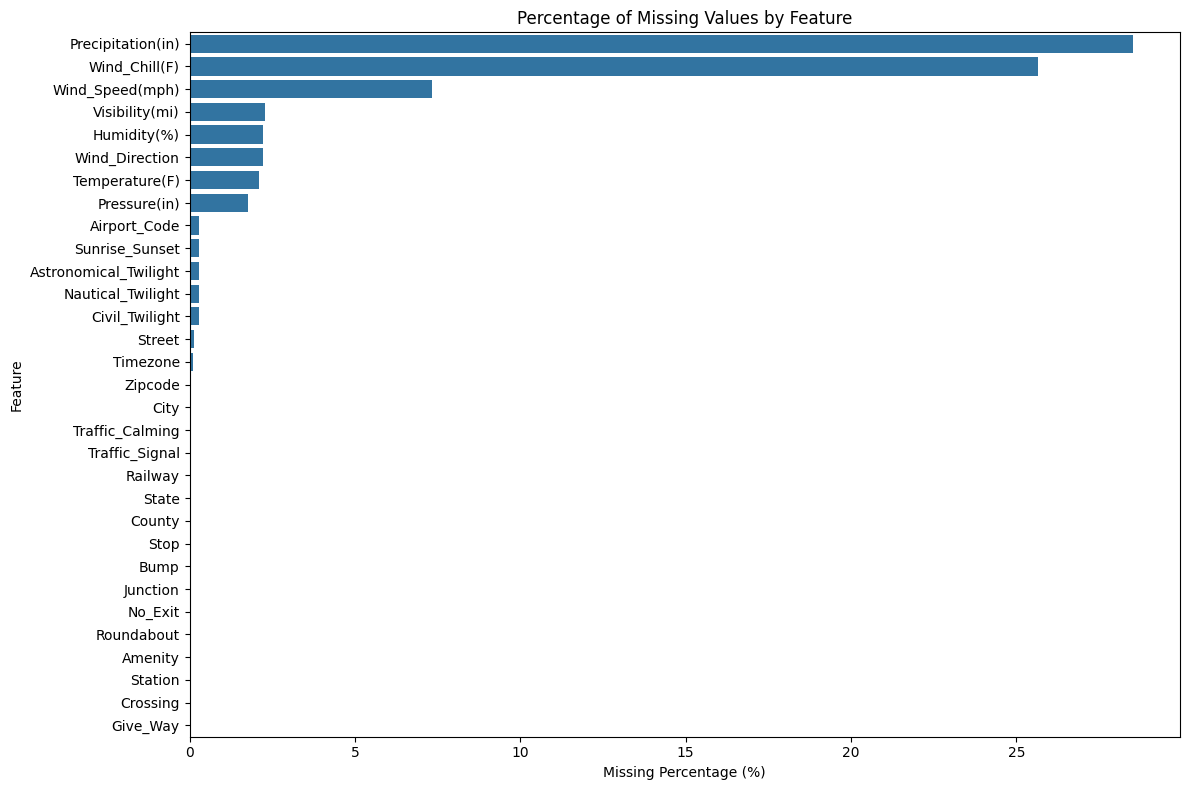

In [29]:
# Plot missing data percentages
plt.figure(figsize=(12, 8))
sns.barplot(x='Missing_Percent(%)', y='Feature', data=missing)
plt.title('Percentage of Missing Values by Feature')
plt.xlabel('Missing Percentage (%)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [30]:
# Wind_Chill(F) has high percentage of missing values (around 25%)
# We'll drop this feature as it's not highly predictive of accident severity
print(f"Missing percentage in Wind_Chill(F): {missing.loc[missing['Feature'] == 'Wind_Chill(F)', 'Missing_Percent(%)'].values[0]:.2f}%")
df = df.drop(['Wind_Chill(F)'], axis=1)

Missing percentage in Wind_Chill(F): 25.66%


In [31]:
# Create a separate feature for missing precipitation data
df['Precipitation_NA'] = 0
df.loc[df['Precipitation(in)'].isnull(), 'Precipitation_NA'] = 1

# Fill missing precipitation values with median
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Precipitation(in)'].median())

# Display first few rows of updated columns
print("Sample of precipitation data after handling missing values:")
print(df.loc[:5, ['Precipitation(in)', 'Precipitation_NA']])

Sample of precipitation data after handling missing values:
   Precipitation(in)  Precipitation_NA
0                0.0                 0
1                0.0                 0
2                0.0                 0
3                0.0                 0
4                0.0                 0
5                0.0                 0


In [32]:
# Count rows before dropping
rows_before = df.shape[0]

# Drop rows with missing values in these columns
drop_features = ['City', 'Zipcode', 'Airport_Code',
                'Sunrise_Sunset', 'Civil_Twilight',
                'Nautical_Twilight', 'Astronomical_Twilight']

df = df.dropna(subset=drop_features)

# Count rows after dropping
rows_after = df.shape[0]
rows_dropped = rows_before - rows_after
drop_percentage = (rows_dropped / rows_before) * 100

print(f"Rows before dropping: {rows_before}")
print(f"Rows after dropping: {rows_after}")
print(f"Rows dropped: {rows_dropped} ({drop_percentage:.2f}%)")

Rows before dropping: 111706
Rows after dropping: 111065
Rows dropped: 641 (0.57%)


In [33]:
import numpy as np

# Group data by 'Airport_Code' and 'Month' then fill NAs with median value
weather_features = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)',
                   'Visibility(mi)', 'Wind_Speed(mph)']

print("Missing values before imputation:")
for feature in weather_features:
    print(f"{feature}: {df[feature].isnull().sum()}")

# Impute missing values by location and month
for feature in weather_features:
    df[feature] = df.groupby(['Airport_Code', 'Month'])[feature].transform(
        lambda x: x.fillna(x.median() if not x.dropna().empty else np.nanmedian(df[feature]))
    )

print("\nRemaining missing values after group imputation:")
for feature in weather_features:
    print(f"{feature}: {df[feature].isnull().sum()}")


Missing values before imputation:
Temperature(F): 2000
Humidity(%): 2153
Pressure(in): 1632
Visibility(mi): 2204
Wind_Speed(mph): 7854

Remaining missing values after group imputation:
Temperature(F): 0
Humidity(%): 0
Pressure(in): 0
Visibility(mi): 0
Wind_Speed(mph): 0


In [34]:
# For records where groupby imputation didn't work (groups with all missing values),
# fill with overall median
for feature in weather_features:
    df[feature] = df[feature].fillna(df[feature].median())

# Check if there are still missing values
print("Missing values after second imputation:")
for feature in weather_features:
    print(f"{feature}: {df[feature].isnull().sum()}")

Missing values after second imputation:
Temperature(F): 0
Humidity(%): 0
Pressure(in): 0
Visibility(mi): 0
Wind_Speed(mph): 0


In [35]:
# Handle Wind_Direction using most common value by Airport_Code and Month
print(f"Missing values in Wind_Direction before imputation: {df['Wind_Direction'].isnull().sum()}")

# Create a copy of the Wind_Direction column to work with
wind_direction_filled = df['Wind_Direction'].copy()

# First, identify the most common Wind_Direction overall to use as a fallback
most_common_direction = df['Wind_Direction'].value_counts().index[0] if not df['Wind_Direction'].value_counts().empty else "CALM"

# For each group, fill missing values with most common value in that group
for (airport, month), group in df.groupby(['Airport_Code', 'Month']):
    # Get the Wind_Direction series for this group
    group_wind = group['Wind_Direction']

    # If the group has at least one non-null value, use the most common value
    if group_wind.notna().any():
        group_most_common = group_wind.value_counts().index[0]
        # Get indices of null values in this group
        null_indices = group_wind[group_wind.isna()].index
        # Fill those indices with the most common value for this group
        wind_direction_filled.loc[null_indices] = group_most_common
    else:
        # If all values in the group are null, use the overall most common value
        null_indices = group_wind.index
        wind_direction_filled.loc[null_indices] = most_common_direction

# Assign the filled values back to the DataFrame
df['Wind_Direction'] = wind_direction_filled

# Fill any remaining missing values with the overall most common value
df['Wind_Direction'] = df['Wind_Direction'].fillna(most_common_direction)

print(f"Missing values in Wind_Direction after imputation: {df['Wind_Direction'].isnull().sum()}")

Missing values in Wind_Direction before imputation: 2129
Missing values in Wind_Direction after imputation: 0


In [36]:
# Check if there are any remaining missing values
remaining_missing = df.isnull().sum()
print("Remaining missing values in the dataset:")
print(remaining_missing[remaining_missing > 0])

# If there are any remaining missing values, drop those rows
if remaining_missing.sum() > 0:
    rows_before = df.shape[0]
    df = df.dropna()
    rows_after = df.shape[0]
    print(f"\nDropped {rows_before - rows_after} rows with remaining missing values")
    print(f"Final dataset shape: {df.shape}")
else:
    print("\nNo missing values remaining in the dataset")
    print(f"Final dataset shape: {df.shape}")

Remaining missing values in the dataset:
Street    154
dtype: int64

Dropped 154 rows with remaining missing values
Final dataset shape: (110911, 48)


## Additional Data Remapping and Plotting

Accident Severity
- 1: Low Severity   
- 2: Medium Severity
- 3: High Severity
- 4: Fatal Severity

3 and 4 are potentially fatal accidents and for the sake of this analysis, we can combine them into a single category representing high severity. 1 and 2 can also be grouped into low severity.

In [37]:
# Create a new column 'HighSeverity' for grouping levels 3 and 4 together
df['HighSeverity'] = 0

# Assign 1 to rows where 'Severity' is either 3 or 4
df.loc[df['Severity'].isin([3, 4]), 'HighSeverity'] = 1

# Drop the original 'Severity' column
df = df.drop(['Severity'], axis=1)

# Check the value counts for the new grouping
df.HighSeverity.value_counts()


<ipython-input-37-01c5b56c6d6c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HighSeverity'] = 0


,count
HighSeverity,
0,89359
1,21552


In [38]:
# Ratio of LowSeverity to HighSeverity
low_severity_count = df['HighSeverity'].value_counts().get(0, 0)
high_severity_count = df['HighSeverity'].value_counts().get(1, 0)
severity_ratio = low_severity_count / high_severity_count
print(f"LowSeverity count: {low_severity_count}")
print(f"HighSeverity count: {high_severity_count}")
print(f"Ratio of LowSeverity to HighSeverity: {severity_ratio:.2f}")


LowSeverity count: 89359
HighSeverity count: 21552
Ratio of LowSeverity to HighSeverity: 4.15


### Accidents Distributed over Years based on Frequency and High/Low Severty

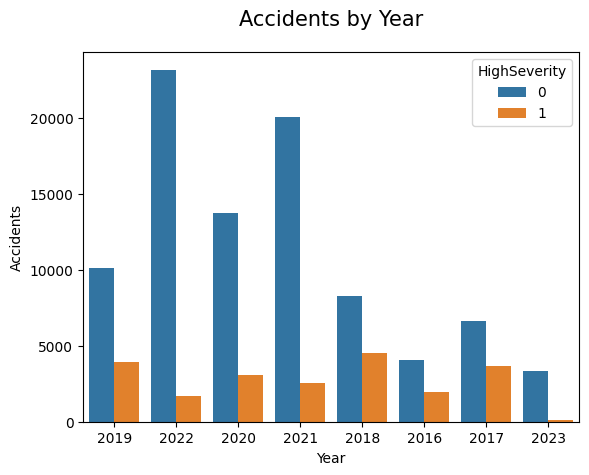

In [39]:
df_p = df.copy()
df_p.Year = df_p.Year.astype(str)
sns.countplot(x='Year', hue='HighSeverity', data=df_p)
plt.rcParams.update({'font.size': 12})
plt.title('Accidents by Year', size=15, y=1.05)
plt.ylabel('Accidents')
plt.show()

### Accidents Distributed over Months based on Frequency and High/Low Severty

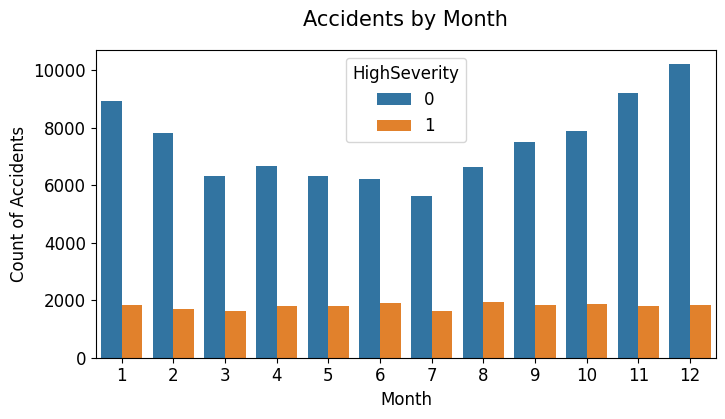

In [40]:
# Count of accidents by month
plt.figure(figsize=(8, 4))
sns.countplot(x='Month', hue='HighSeverity', data=df_p)
plt.title('Accidents by Month', size=15, y=1.05)
plt.xlabel('Month')
plt.ylabel('Count of Accidents')
plt.show()


### Accidents Distributed over Weekdays based on Frequency and High/Low Severty

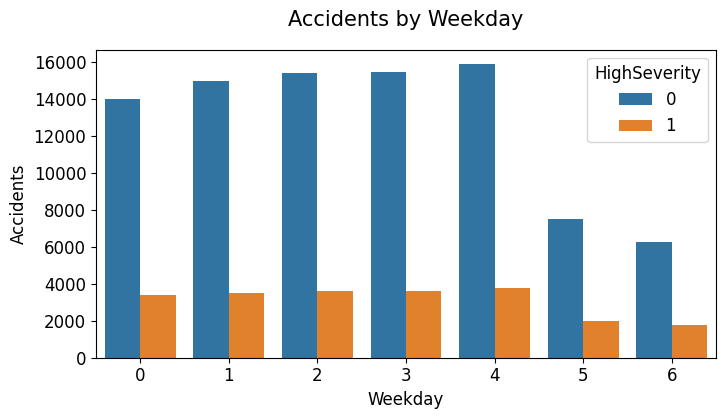

In [41]:
plt.figure(figsize=(8,4))
sns.countplot(x='Weekday', hue='HighSeverity', data=df_p)
plt.title('Accidents by Weekday', size=15, y=1.05)
plt.ylabel('Accidents')
plt.show()

### Heat Map of HighSeverity by Hour

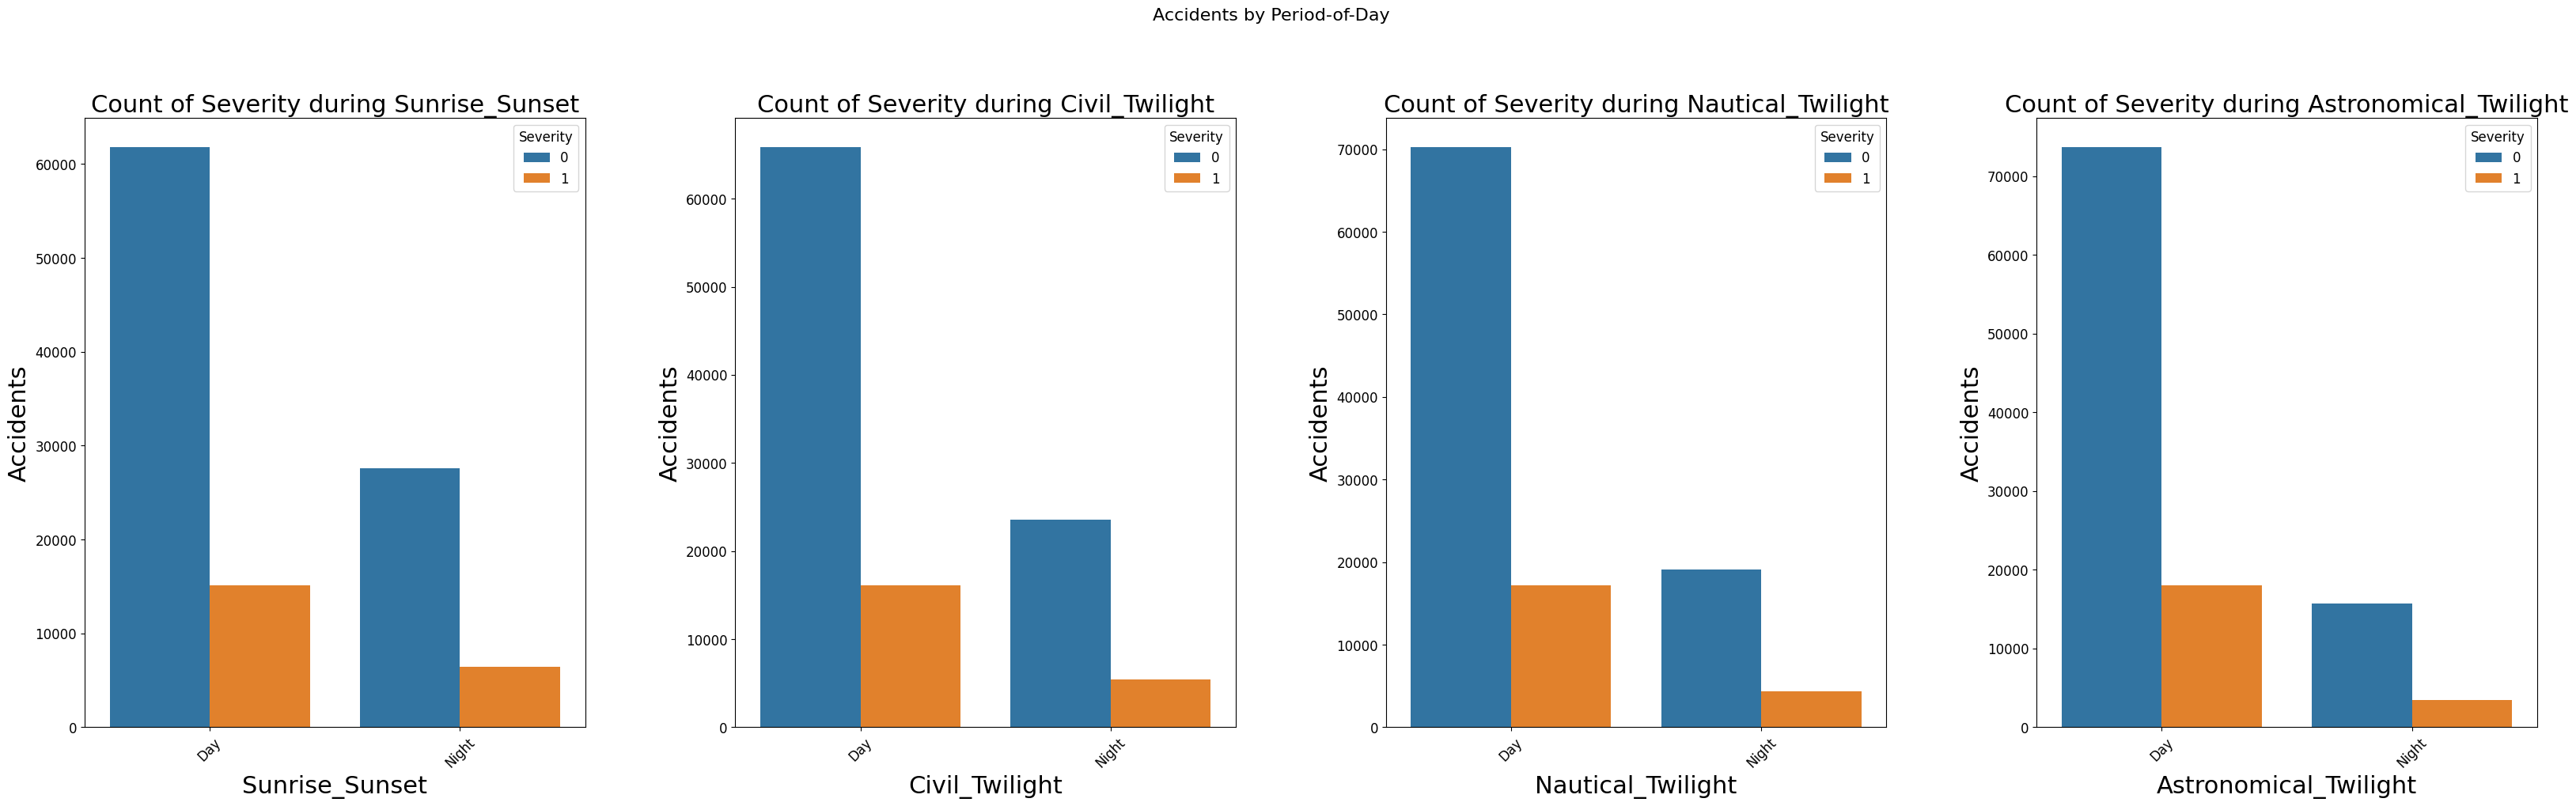

In [42]:
period_features = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

# Initialize the figure and axes
fig, axs = plt.subplots(nrows=1, ncols=len(period_features), figsize=(40, 10))
plt.subplots_adjust(wspace=0.3)  # Adjust spacing between subplots

# Loop through features to generate subplots
for i, feature in enumerate(period_features):
    sns.countplot(ax=axs[i], x=feature, hue='HighSeverity', data=df_p)
    axs[i].set_title(f'Count of Severity during {feature}', fontsize=22)
    axs[i].set_xlabel(f'{feature}', fontsize=22)
    axs[i].set_ylabel('Accidents', fontsize=22)
    axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
    axs[i].legend(title='Severity', loc='upper right')

# Set overall title
fig.suptitle('Accidents by Period-of-Day', y=1.02, fontsize=16)
plt.show()

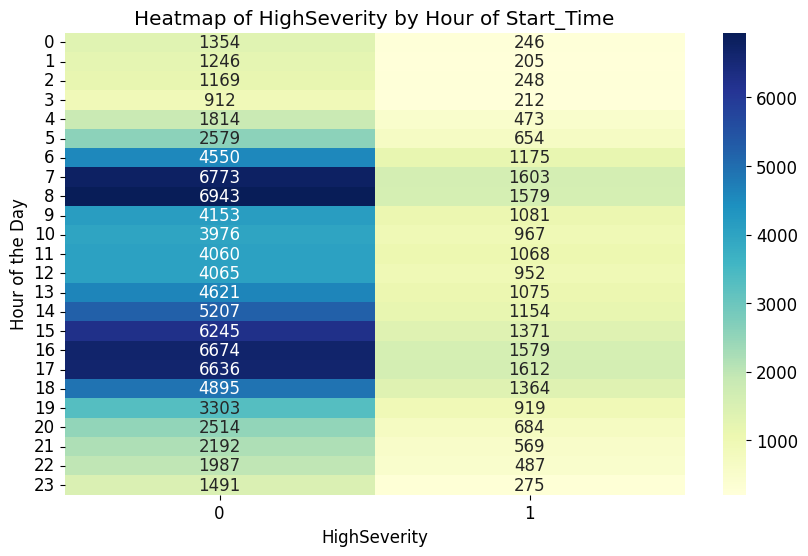

In [43]:
# Group data by 'Hour' and 'HighSeverity', counting occurrences
heatmap_data = df.groupby(['Hour', 'HighSeverity']).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
#font size of this plot
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Heatmap of HighSeverity by Hour of Start_Time')
plt.xlabel('HighSeverity')
plt.ylabel('Hour of the Day')
plt.show()



This Heatmap indicated high level of recorded accidents between 5AM to 7PM

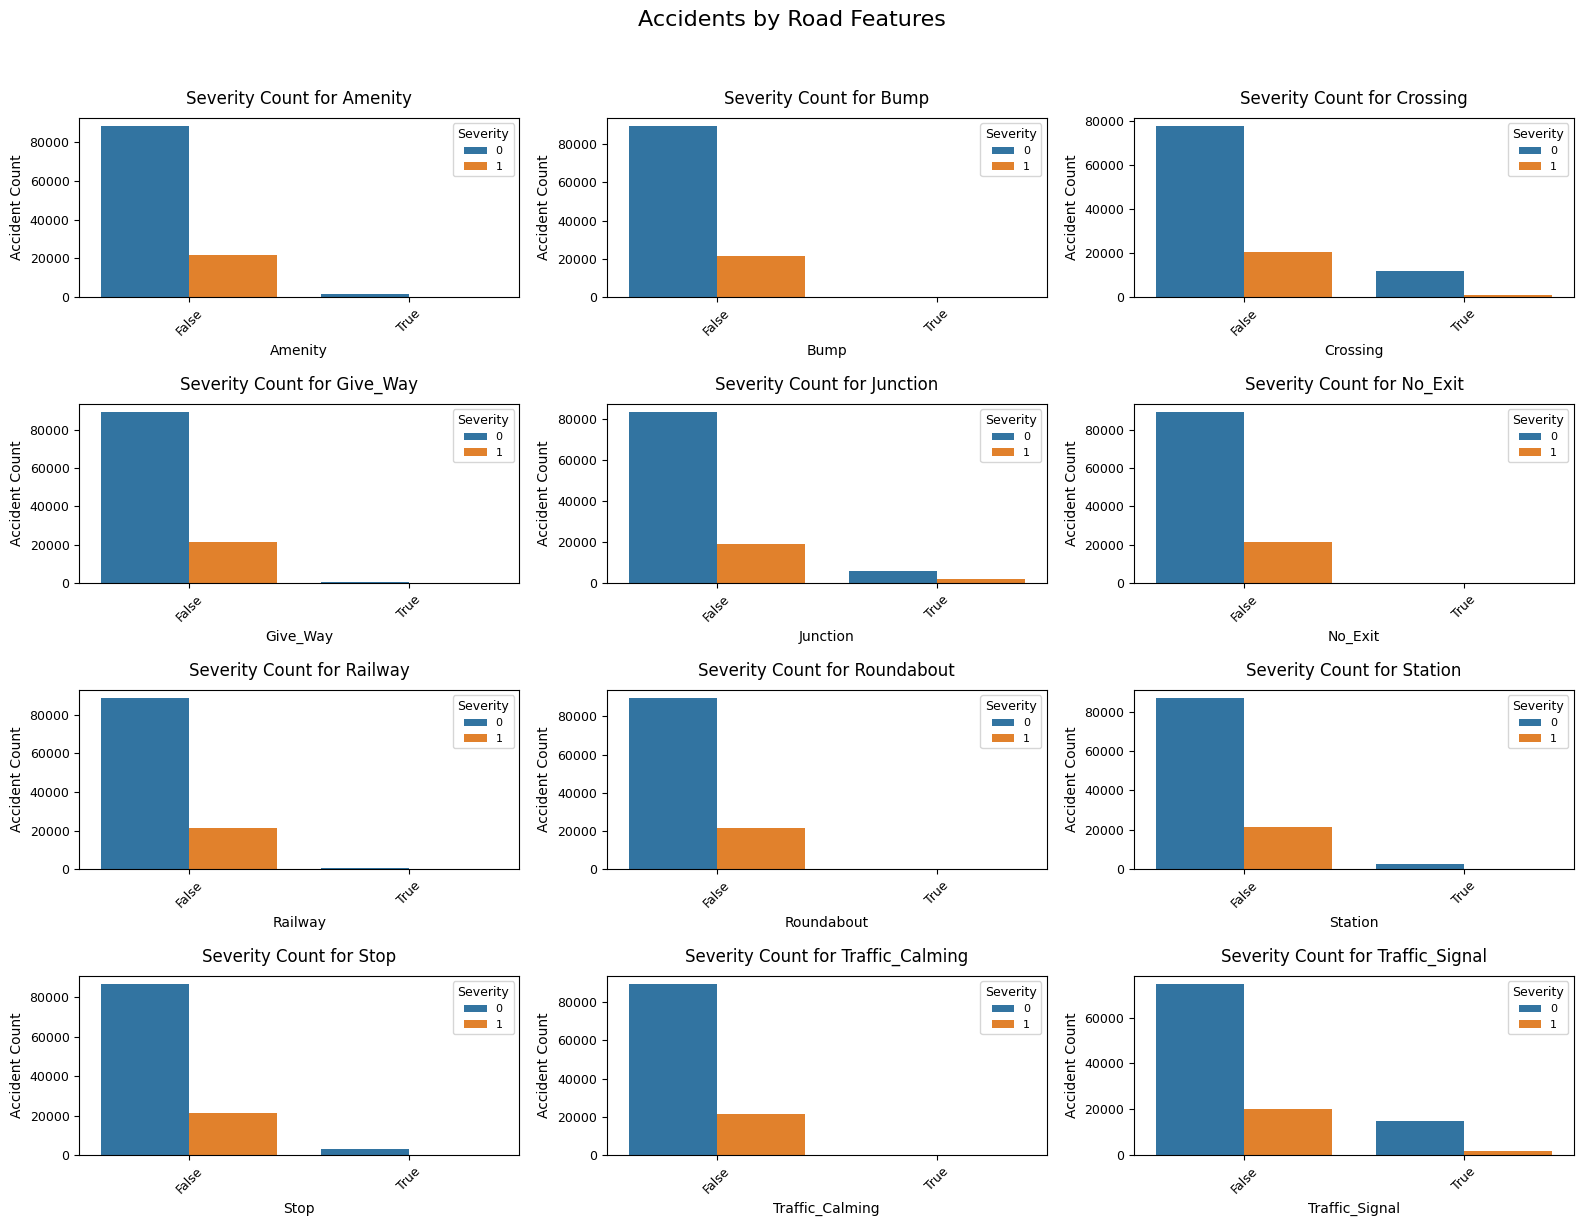

In [44]:
road_features = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
                'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

# Set up the figure with 3 columns and 4 rows
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(16, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.4)  # Add spacing between plots

# Loop through features and plot each one
for i, feature in enumerate(road_features):
    row, col = divmod(i, 3)  # Calculate subplot position
    ax = axs[row, col]  # Get the corresponding subplot axis

    # Plot countplot for each feature
    sns.countplot(x=feature, hue='HighSeverity', data=df_p, ax=ax)

    # Customize labels and titles
    ax.set_title(f'Severity Count for {feature}', fontsize=12, pad=10)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Accident Count', fontsize=10)
    ax.tick_params(axis='x', labelsize=9, rotation=45)  # Rotate x-axis labels for clarity
    ax.tick_params(axis='y', labelsize=9)

    # Adjust legend for better fit
    ax.legend(title='Severity', loc='upper right', fontsize=8, title_fontsize=9)

# Remove unused subplots
for j in range(len(road_features), 12):  # Total grid cells are 3x4=12
    fig.delaxes(axs.flat[j])  # Remove extra axes

# Add a main title for the whole figure
fig.suptitle('Accidents by Road Features', fontsize=16, y=1.02)
plt.tight_layout()  # Adjust layout to prevent overlaps
plt.show()

In [45]:
from scipy.stats import boxcox

# Applying boxcox transformation to make Pressure, Visibility, and Wind_Speed normal and minimize skewness

df_p['Pressure_n']= boxcox(df['Pressure(in)'].apply(lambda x: x+1),lmbda=13)
df_p['Visibility_n']= boxcox(df['Visibility(mi)'].apply(lambda x: x+1),lmbda = 0.8)
df_p['Wind_Speed_n']= boxcox(df['Wind_Speed(mph)'].apply(lambda x: x+1),lmbda=0.4)

df_p = df_p.drop(['Pressure(in)','Visibility(mi)','Wind_Speed(mph)'], axis=1)




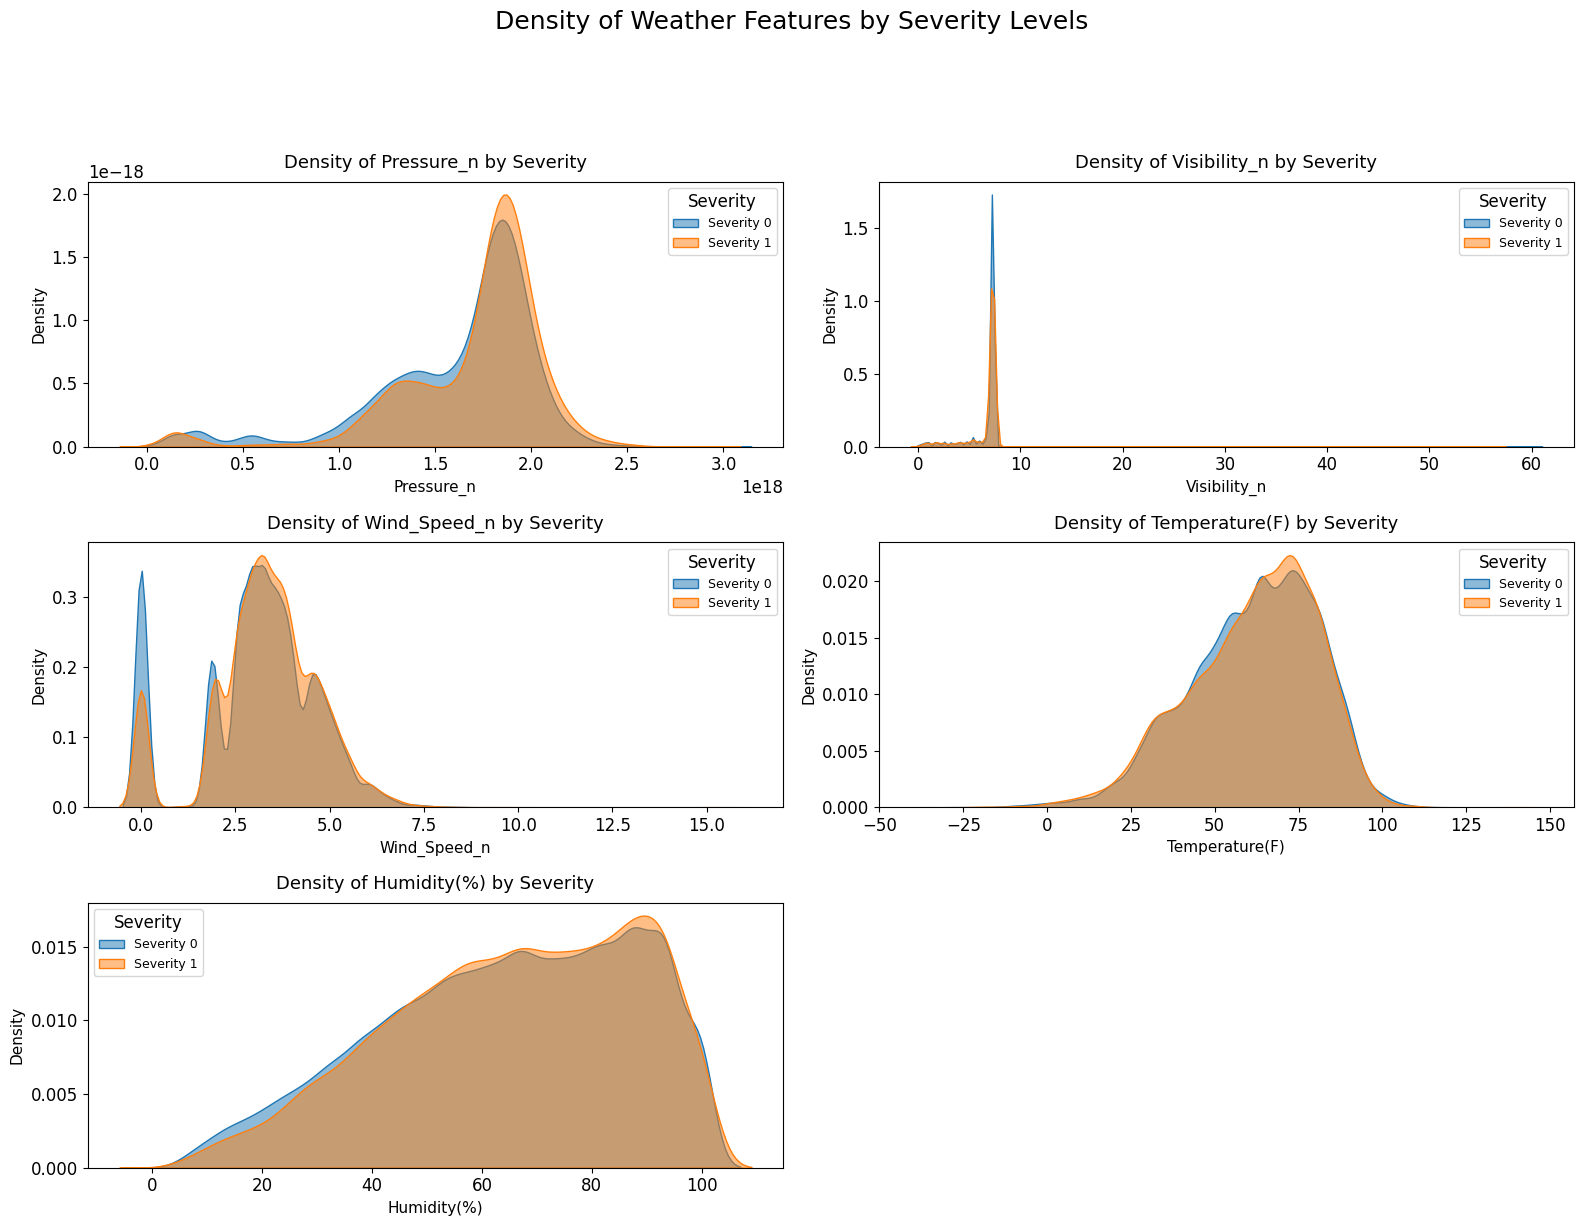

In [46]:
# Ensure HighSeverity is categorical
df_p['HighSeverity'] = df_p['HighSeverity'].astype('category')

# Define numerical features to plot
num_features = ['Pressure_n', 'Visibility_n', 'Wind_Speed_n', 'Temperature(F)', 'Humidity(%)']

# Validate that all features exist in the dataframe
missing_features = [feature for feature in num_features if feature not in df_p.columns]
if missing_features:
    raise ValueError(f"The following features are missing from df_p: {missing_features}")

# Create subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))  # Adjust layout for clarity
fig.subplots_adjust(hspace=0.5, wspace=0.4)  # Add spacing between plots

# Iterate through features and create density plots
for i, feature in enumerate(num_features):
    row, col = divmod(i, 2)  # Calculate subplot position
    for severity in df_p['HighSeverity'].cat.categories:
        subset = df_p[df_p['HighSeverity'] == severity]
        sns.kdeplot(ax=axs[row, col], x=subset[feature], label=f'Severity {severity}', fill=True, alpha=0.5)

    # Customize each subplot
    axs[row, col].set_title(f'Density of {feature} by Severity', fontsize=13, pad=10)
    axs[row, col].set_xlabel(feature, fontsize=11)
    axs[row, col].set_ylabel('Density', fontsize=11)
    axs[row, col].legend(title='Severity', fontsize=9)

# Remove unused subplot (if applicable)
if len(num_features) < 6:  # Total grid cells = 3 * 2 = 6
    for j in range(len(num_features), 6):
        fig.delaxes(axs.flat[j])

# Add a main title for the entire figure
fig.suptitle('Density of Weather Features by Severity Levels', fontsize=18, y=1.02)

# Adjust layout boundaries
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Prevent overlaps
plt.show()



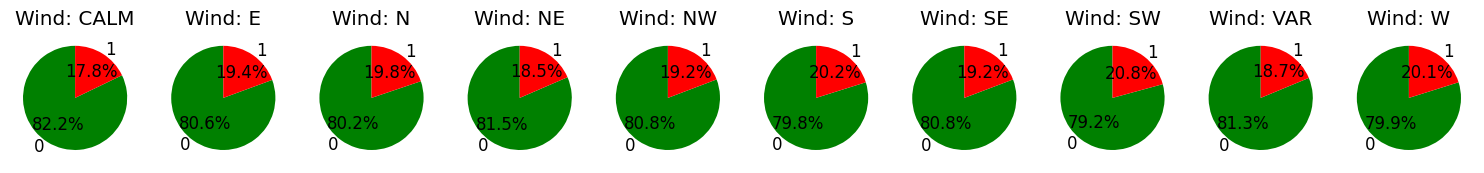

In [47]:
df_pivot = df_p.groupby('Wind_Direction')['HighSeverity'].value_counts(normalize=True).unstack()

# Creating a pie chart for each Wind_Direction
fig, axes = plt.subplots(nrows=1, ncols=len(df_pivot), figsize=(15, 6), subplot_kw={'aspect': 'equal'})

for ax, (direction, values) in zip(axes, df_pivot.iterrows()):
    values.plot.pie(ax=ax, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
    ax.set_title(f'Wind: {direction}')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

## One-hot Encoding
One-hot encode categorical features.

In [48]:
df_p = df_p.astype({col: int for col in df_p.select_dtypes(bool).columns})

In [49]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110911 entries, 0 to 111704
Data columns (total 48 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Start_Time             110911 non-null  datetime64[ns]
 1   Start_Lat              110911 non-null  float64       
 2   Start_Lng              110911 non-null  float64       
 3   Street                 110911 non-null  object        
 4   City                   110911 non-null  object        
 5   County                 110911 non-null  object        
 6   State                  110911 non-null  object        
 7   Zipcode                110911 non-null  object        
 8   Timezone               110911 non-null  object        
 9   Airport_Code           110911 non-null  object        
 10  Temperature(F)         110911 non-null  float64       
 11  Humidity(%)            110911 non-null  float64       
 12  Wind_Direction         110911 non-null  object   

In [50]:
cat = ['City','Timezone']
df_p[cat] = df_p[cat].astype('category')
df_p = pd.get_dummies(df_p, columns=cat, drop_first=True)

df_int = df_p.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df_float = df_p.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
label_col = df_p['HighSeverity']
df_p = pd.concat([df_p.select_dtypes(include=['uint8']),df_int,df_float,label_col],axis=1)
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110911 entries, 0 to 111704
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Month              110911 non-null  uint8   
 1   Weekday            110911 non-null  uint8   
 2   Day                110911 non-null  uint16  
 3   Hour               110911 non-null  uint8   
 4   Clear              110911 non-null  uint8   
 5   Cloud              110911 non-null  uint8   
 6   Rain               110911 non-null  uint8   
 7   Heavy_Rain         110911 non-null  uint8   
 8   Snow               110911 non-null  uint8   
 9   Heavy_Snow         110911 non-null  uint8   
 10  Fog                110911 non-null  uint8   
 11  Precipitation_NA   110911 non-null  uint8   
 12  Start_Lat          110911 non-null  float32 
 13  Start_Lng          110911 non-null  float32 
 14  Temperature(F)     110911 non-null  float32 
 15  Humidity(%)        110911 non-null  flo

In [51]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

## Train Test Split

In [52]:
print(df_p.columns)
print(df_p.head())

Index(['Month', 'Weekday', 'Day', 'Hour', 'Clear', 'Cloud', 'Rain',
       'Heavy_Rain', 'Snow', 'Heavy_Snow', 'Fog', 'Precipitation_NA',
       'Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)',
       'Precipitation(in)', 'Minute', 'Pressure_n', 'Visibility_n',
       'Wind_Speed_n', 'HighSeverity'],
      dtype='object')
   Month  Weekday  Day  Hour  Clear  Cloud  Rain  Heavy_Rain  Snow  \
0      6        2  163    10      0      0     0           0     0   
1     12        5  337    23      0      0     0           0     0   
2      8        5  232    13      0      0     0           0     0   
3      2        0   52    17      0      0     0           0     0   
4     12        4  338     1      0      0     0           0     0   

   Heavy_Snow  ...  Start_Lat   Start_Lng  Temperature(F)  Humidity(%)  \
0           0  ...  30.641211  -91.153481            77.0         62.0   
1           0  ...  38.990562  -77.399071            45.0         48.0   
2           0  ...  34.

In [53]:
X = df_p.drop('HighSeverity', axis=1)
y = df_p['HighSeverity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [54]:
rus = RandomUnderSampler(sampling_strategy = 0.5, random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

Distribution of class labels before resampling Counter({0: 62535, 1: 15102})
Distribution of class labels after resampling Counter({0: 30204, 1: 15102})


In [55]:
print(f"Original dataset: {len(df_p)} samples")
print(f"Train size before resampling: {len(y_train)}")
print(f"Train size after resampling: {len(y_train_res)}")
print(f"X_train_res shape: {X_train_res.shape}")
print(f"Test size: {len(y_test)}")
print(f"Resampled class distribution: {Counter(y_train_res)}")

Original dataset: 110911 samples
Train size before resampling: 77637
Train size after resampling: 45306
X_train_res shape: (45306, 21)
Test size: 33274
Resampled class distribution: Counter({0: 30204, 1: 15102})


In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [57]:
clf_base = LogisticRegression(solver='liblinear', max_iter=1000)
grid = {
    'C': 10.0 ** np.arange(-3, 4),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced']
}
clf_lr = GridSearchCV(clf_base, grid, cv=5, n_jobs=-1, scoring='f1_macro')
clf_lr.fit(X_train_scaled, y_train_res)

y_pred_proba_lr = clf_lr.predict_proba(X_test_scaled)[:, 1]
y_pred_lr = (y_pred_proba_lr > 0.5).astype(int)

print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.87      0.69      0.77     26824
           1       0.30      0.56      0.39      6450

    accuracy                           0.66     33274
   macro avg       0.58      0.62      0.58     33274
weighted avg       0.76      0.66      0.69     33274



In [58]:
print("Best params:", clf_lr.best_params_)
print("Best CV score:", clf_lr.best_score_)

Best params: {'C': np.float64(0.001), 'class_weight': 'balanced', 'penalty': 'l2'}
Best CV score: 0.6147589999680612


### KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]
y_pred_knn = (y_pred_proba_knn > 0.5).astype(int)

print("KNN:\n", classification_report(y_test, y_pred_knn))


KNN:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87     26824
           1       0.36      0.16      0.22      6450

    accuracy                           0.78     33274
   macro avg       0.59      0.55      0.55     33274
weighted avg       0.73      0.78      0.75     33274



### Random Forest

In [60]:
# Drop from train and test sets
X_train_rf = X_train_res
X_test_rf = X_test

print("New training shape:", X_train_rf.shape)
print("New test shape:", X_test_rf.shape)


New training shape: (45306, 21)
New test shape: (33274, 21)


In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

clf_base = RandomForestClassifier(class_weight='balanced', random_state=42)
grid = {
    'n_estimators': [50, 100],
    'max_features': ['sqrt'],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5]
}
clf_rf = RandomizedSearchCV(clf_base, grid, cv=5, n_iter=10, n_jobs=-1,
                            scoring='f1_macro', random_state=42)

clf_rf.fit(X_train_rf, y_train_res)

y_pred_proba_rf = clf_rf.predict_proba(X_test_rf)[:, 1]
y_pred_rf = (y_pred_proba_rf > 0.5).astype(int)



print("Random Forest:\n", classification_report(y_test, y_pred_rf))


Random Forest:
               precision    recall  f1-score   support

           0       0.88      0.77      0.83     26824
           1       0.38      0.58      0.46      6450

    accuracy                           0.74     33274
   macro avg       0.63      0.68      0.64     33274
weighted avg       0.79      0.74      0.75     33274



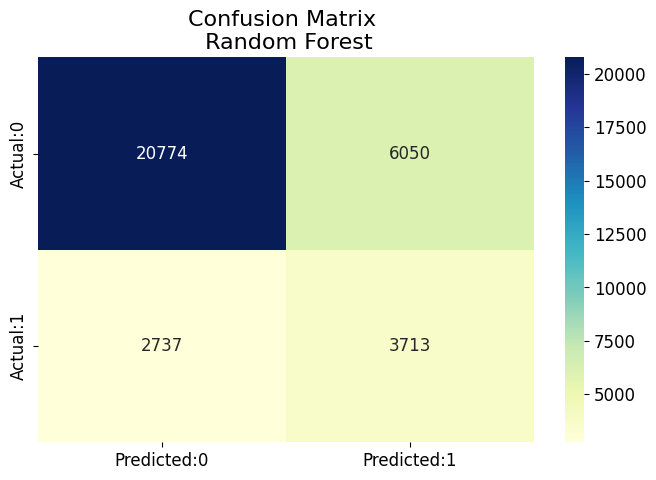

In [62]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_rf)

conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu").set_title(
    "Confusion Matrix \n Random Forest", fontsize=16)
plt.show()

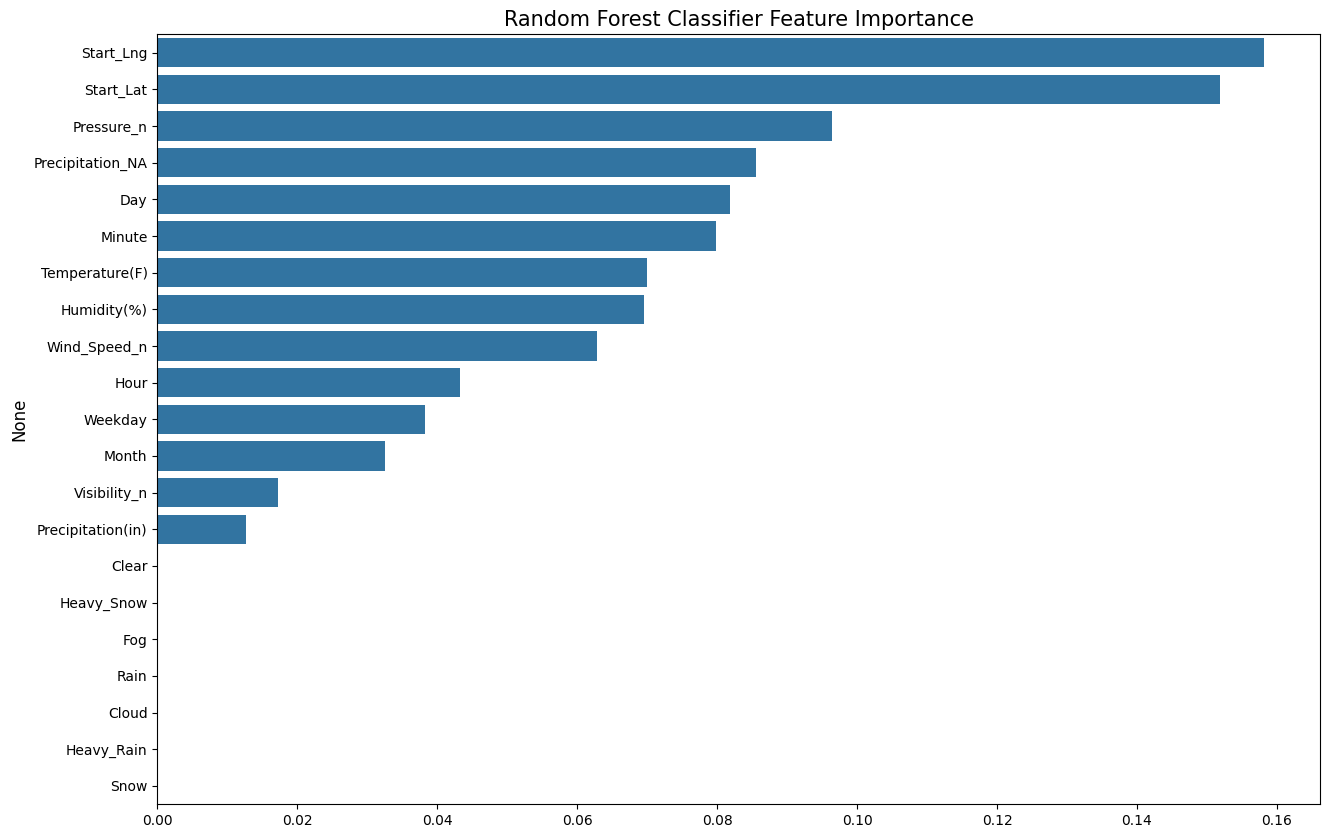

In [63]:
importances = pd.DataFrame(np.zeros((X_train_rf.shape[1], 1)), columns=['importance'], index=X_train_rf.columns)

importances.iloc[:, 0] = clf_rf.best_estimator_.feature_importances_

importances.sort_values(by='importance', inplace=True, ascending=False)
importances30 = importances.head(30)

plt.figure(figsize=(15, 10))
sns.barplot(x='importance', y=importances30.index, data=importances30)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Random Forest Classifier Feature Importance', size=15)

plt.show()


### Ensemble

In [64]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

def multi_rus(X, y, n_folds, ratio):
    X_resampled = []
    y_resampled = []
    for i in range(n_folds):
        rus = RandomUnderSampler(sampling_strategy=ratio, random_state=42 + i)  # vary seed slightly
        X_r, y_r = rus.fit_resample(X, y)
        X_resampled.append(X_r)
        y_resampled.append(y_r)
    return X_resampled, y_resampled

# Generate multiple resampled sets
X_res_folds, y_res_folds = multi_rus(X_train, y_train, n_folds=3, ratio=0.5)




In [65]:
avg_proba_ens3 = np.zeros(len(y_test))
for X_fold, y_fold in zip(X_res_folds, y_res_folds):
    clf = RandomForestClassifier(n_estimators=100, max_features='sqrt',
                                 class_weight='balanced', random_state=42)
    clf.fit(X_fold, y_fold)
    avg_proba_ens3 += clf.predict_proba(X_test)[:, 1]

avg_proba_ens3 /= len(X_res_folds)
y_pred_ens3 = (avg_proba_ens3 > 0.5).astype(int)

print("3-Fold Ensemble:\n", classification_report(y_test, y_pred_ens3))


3-Fold Ensemble:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88     26824
           1       0.46      0.36      0.40      6450

    accuracy                           0.79     33274
   macro avg       0.66      0.63      0.64     33274
weighted avg       0.78      0.79      0.78     33274



In [66]:
X_train_res, y_train_res = multi_rus(X_train, y_train, 9, 0.5)
avg_proba_ens9 = np.zeros(len(y_test))

for i in range(len(y_train_res)):
    clf = RandomForestClassifier(n_estimators=100, max_features='sqrt',
                                 random_state=42 + i)
    clf.fit(X_train_res[i], y_train_res[i])
    avg_proba_ens9 += clf.predict_proba(X_test)[:, 1]

avg_proba_ens9 /= len(y_train_res)
y_pred_ens9 = (avg_proba_ens9 > 0.5).astype(int)

print("9-Fold Ensemble:\n", classification_report(y_test, y_pred_ens9))


9-Fold Ensemble:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88     26824
           1       0.47      0.39      0.43      6450

    accuracy                           0.79     33274
   macro avg       0.66      0.64      0.65     33274
weighted avg       0.78      0.79      0.79     33274



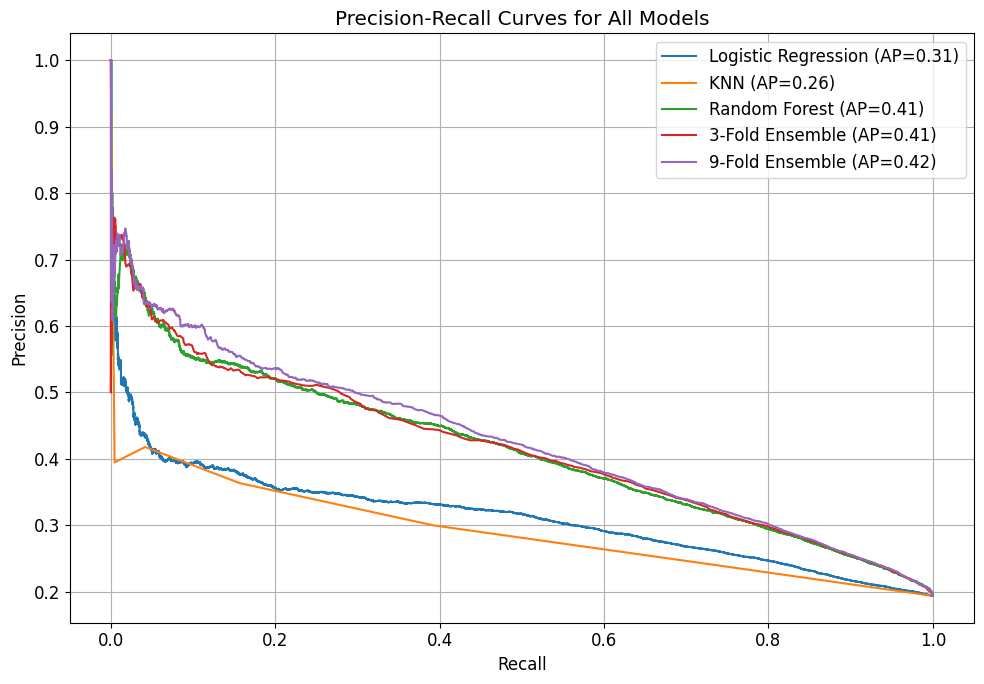

In [67]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

model_outputs = {
    "Logistic Regression": y_pred_proba_lr,
    "KNN": y_pred_proba_knn,
    "Random Forest": y_pred_proba_rf,
    "3-Fold Ensemble": avg_proba_ens3,
    "9-Fold Ensemble": avg_proba_ens9
}

plt.figure(figsize=(10, 7))

for name, proba in model_outputs.items():
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




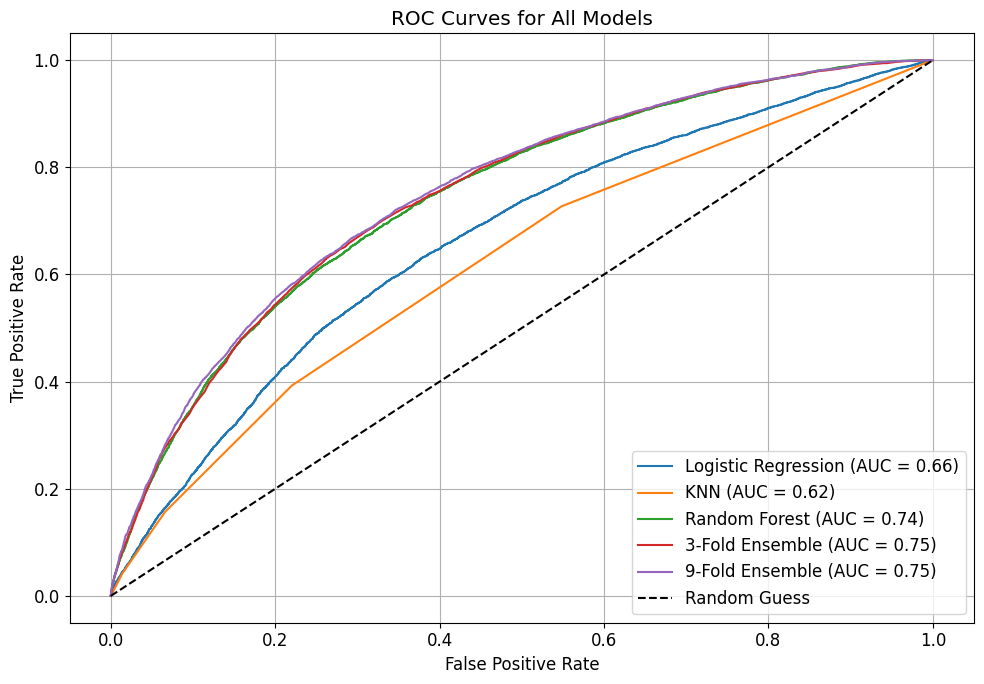

In [68]:
model_probas = {
    "Logistic Regression": y_pred_proba_lr,
    "KNN": y_pred_proba_knn,
    "Random Forest": y_pred_proba_rf,
    "3-Fold Ensemble": avg_proba_ens3,
    "9-Fold Ensemble": avg_proba_ens9
}

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

for name, proba in model_probas.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

# Plot random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
